# Visual Question Answering (VQA) with Frozen LLMs

In [ ]:
"""
Multimodal image and language modeling

As vision and language models became more powerful, Visual Question Answering gave way to
Visual Language Modeling (VLM), which can generally be considered as an expansion on visual question
answering. This shift from VQA to VLM was largely the result of incorporating large language models
into visual systems. The difficulty of visual language modeling is, and always has been, multi-modality.

The BLIP-2 paper proposes the Q-Former to address both the catastrophic forgetting issue, as well
as being economical by leveraging existing models. (https://arxiv.org/abs/2301.12597)
"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
!pip install -U bitsandbytes

In [3]:
"""
Downloading the BLIP-2 architecture - loading as an 8 bit integer to save on GPU
memory. This may have some impact on performance.
"""

from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor= AutoProcessor.from_pretrained('Salesforce/blip2-opt-2.7b')
model= Blip2ForConditionalGeneration.from_pretrained('Salesforce/blip2-opt-2.7b', device_map='auto',
                                                     load_in_8bit=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the f

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Image dimensions: 4608px X 6144px


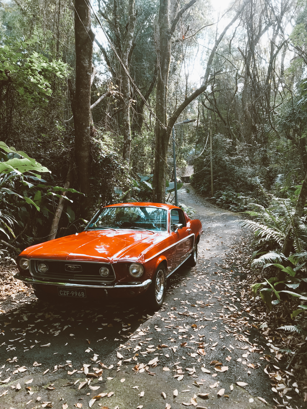

In [4]:
# loading and displaying a sample image

import requests
from PIL import Image

url= 'https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Images/pexels-thuany-marcante-1805053.jpg?raw=true'
image= Image.open(requests.get(url, stream=True).raw).convert('RGB')

print(f'Image dimensions: {image.width}px X {image.height}px')

dsfact= 15
display(image.resize((int(image.width/dsfact), int(image.height/dsfact))))

In [5]:
# exploring the outputs of the processor

processor_result= processor(image, text='A prompt from the user about the image',
                            return_tensors='pt').to('cpu', torch.float16)
processor_result.keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])

Processed image shape: (1, 3, 224, 224)
Single color channel:


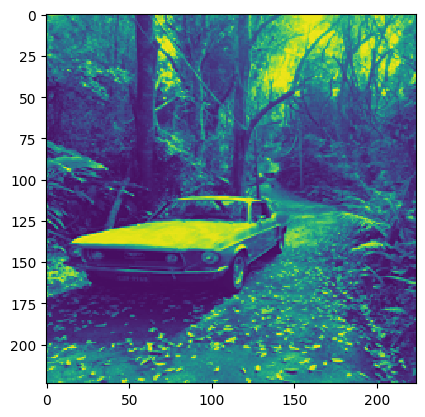

In [7]:
"""
The pixel_values from the processor are a transformation of the image down to 224 x 224, with
the color values normalized to a convenient range for modeling.
"""

# understanding resolution and plotting one of the color channels

# printing the processed image shape
print(f"Processed image shape: {processor_result['pixel_values'].numpy().shape}")

# extracting one of the color channels from the processed image
print('Single color channel:')
processed_im_c0= processor_result['pixel_values'].numpy()[0,0]

# rendering
plt.imshow(processed_im_c0, interpolation='nearest')
plt.show()

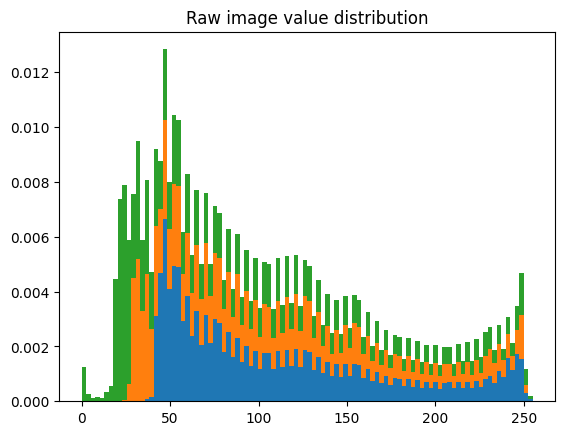

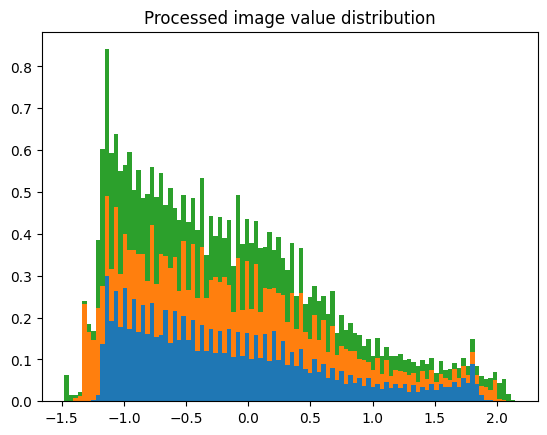

In [9]:
# understanding the distribution of values allong each color channel, both
# in the processed image and in the original image

bins= 100

# plotting original plixel value distributions
image_np= np.array(image)

plt.figure()
plt.hist([image_np[:,:,0].flatten(),
          image_np[:,:,1].flatten(),
          image_np[:,:,2].flatten()], bins, stacked=True, density=True)
plt.title('Raw image value distribution')
plt.show()
# the values for the raw image have a biased distribution which spans a much wider range of values


# extracting all color channels from the processed image
processed_im_c1= processor_result['pixel_values'].numpy()[0,1]
processed_im_c2= processor_result['pixel_values'].numpy()[0,2]

#plotting modified pixel value distributions
plt.figure()
plt.hist([processed_im_c0.flatten(),
          processed_im_c1.flatten(),
          processed_im_c2.flatten()], bins, stacked=True, density=True)
plt.title('Processed image value distribution')
plt.show()
# the values for the processed images are reduced within a reasonable range, and they seem to be
# averaged around

In [10]:
"""
The input_ids from the processor are word piece indexes. Individual parts of a sentence are
assigned individual indexes, which are later used in a word to vector embedder, which is then
applied to the BLIP-2.
"""

# exploring the input_ids from the processor given a variety of prompts

print('input_ids for "a short prompt":')
samples= processor(image, text='a short prompt', return_tensors='pt').to('cpu', torch.float16)
print(samples['input_ids'])

print('input_ids for "a much much much much longer prompt":')
samples= processor(image, text='a much much much much longer prompt',
                   return_tensors='pt').to('cpu', torch.float16)
print(samples['input_ids'])

print('input_ids for "alongcompoundword":')
samples= processor(image, text='alongcompoundword', return_tensors='pt').to('cpu', torch.float16)
print(samples['input_ids'])

input_ids for "a short prompt":
tensor([[    2,   102,   765, 14302]])
input_ids for "a much much much much longer prompt":
tensor([[    2,   102,   203,   203,   203,   203,  1181, 14302]])
input_ids for "alongcompoundword":
tensor([[    2, 20774, 11828,  9834, 14742]])


In [11]:
"""
Because we're inferencing the model, the mask provided by the processor is simply all 1's,
allowing the model to see all input values
"""

# understanding the mask from the processor
print('input_ids for "a short prompt":')
samples= processor(image, text='a short prompt', return_tensors='pt').to('cpu', torch.float16)
print(samples['input_ids'])

print('Mask for "a short prompt":')
print(samples['attention_mask'])

input_ids for "a short prompt":
tensor([[    2,   102,   765, 14302]])
Mask for "a short prompt":
tensor([[1, 1, 1, 1]])


# Invoking the Model

In [14]:
"""
Getting BLIP-2 to describe the image, unprompted this is done by only passing the image,
not the text

Image Captioning: BLIP-2 will caption an image if you provide it an image and no text
"""

inputs= processor(image, return_tensors='pt').to('cpu', torch.float16)

generated_ids= model.generate(**inputs, max_new_tokens=20)
generated_text= processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


an orange car parked in the woods


# Prompted Image Captioning

In [15]:
"""
If you provide a prefix to a caption, BLIP-2 will try to complete  the caption
"""

prompt= 'this is a picture of'

inputs= processor(image, text=prompt, return_tensors='pt').to('cpu', torch.float16)

generated_ids= model.generate(**inputs, max_new_tokens=20)
generated_text= processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


an orange car parked in the woods


In [16]:
"""
Prompted caption example 2
"""

prompt= 'the weather looks'

inputs= processor(image, text=prompt, return_tensors='pt').to('cpu', torch.float16)

generated_ids= model.generate(**inputs, max_new_tokens=20)
generated_text= processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


like it's going to be perfect for a drive


# Visual Question Answering

In [17]:
"""
By invoking BLIP-2 with a specially formatted query, visual question answering
can be achieved without ever having trained on visual question answering data.
"""

prompt= 'Question: what season is it? Answer:'

inputs= processor(image, text=prompt, return_tensors='pt').to('cpu', torch.float16)

generated_ids= model.generate(**inputs, max_new_tokens=20)
generated_text= processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


it's autumn


# Visually Based Conversations

In [19]:
"""
We can format our prompts into something resembling a conversation, thus allowing
us to converse with the model about an image
"""

# imagine these are generated by a person as a response to output, rather than pre-defined
questions= [
    "What is in this photo?",
    "What is vernacular architecture?"
]

# defining the state of the conversation as it progresses, to be passed to the model
conv_state= ''

# asking alls questions in order
for question in questions:

    # updating the conversational state with the question
    conv_state= conv_state+' Question: '+ question +'Answer: '

    # passing the state thus far to the model
    inputs= processor(image, text=conv_state, return_tensors='pt').to('cpu', torch.float16)

    # generating a response
    generated_ids= model.generate(**inputs, max_new_tokens=40)
    generated_text= processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # rendering conversation
    print('Question: '+question)
    print('Answer: '+generated_text)

    # updating the conversational state with the answer
    conv_state= conv_state + generated_text + '\n'

Both `max_new_tokens` (=40) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Question: What is in this photo?
Answer: vernacular architecture, a classic car, and a forest


Both `max_new_tokens` (=40) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Question: What is vernacular architecture?
Answer: vernacular architecture is a style of architecture that is built in a way that is familiar to the people who live in the area


In [ ]:
# https://towardsdatascience.com/visual-question-answering-with-frozen-large-language-models-353d42791054